In [2]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os
import category_encoders as ce

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor

In [3]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.2)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", r2_score(y_true, y_pred))
    print("RMSE: ", (mean_squared_error(y_true, y_pred)) ** 0.5)

In [4]:
# Read csv into dataframe.
df = pd.read_csv('Data/210907_Essay_score_cleaned_3.csv')

In [5]:
# Deal with isna's and dtypes.
cols = ['Major', 'Field']
for c in cols:
    df[c] = df[c].fillna('N/A')
df = df.drop(['Unnamed: 0', 'Code'], axis=1)

In [6]:
df.describe()

,PTJ1,SMK1,Age,Grade,VST,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna
count,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000
mean,236.497692,227.321538,19.660769,1.796538,33.592308,4.720246,4.758304,3.128846,3.735196,4.155612,4.093146,3.599981,4.154231,4.189808,3.575673,3.824454,3.986154,4.365769,4.235769,4.322308,5.769615,7.210908,136.748077,0.926154,0.850769,0.774615
std,32.847801,29.174596,1.971400,1.054748,8.692114,0.767689,0.770518,1.311496,0.999629,0.991820,0.892198,1.000278,0.927779,0.923321,1.040804,1.025481,1.515027,1.308973,1.290519,1.368854,20.585439,17.970802,261.741791,0.261571,0.356384,0.417916
min,176.000000,175.000000,15.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.750000,0.000000,1.000000,1.000000,1.000000,1.000000,0.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,212.000000,206.000000,18.000000,1.000000,27.000000,4.330000,4.330000,2.000000,3.130000,3.500000,3.560000,3.000000,3.500000,3.500000,3.000000,3.250000,3.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,226.000000,217.000000,19.000000,2.000000,34.000000,4.830000,4.830000,3.000000,3.750000,4.250000,4.110000,3.560000,4.250000,4.250000,3.500000,3.750000,4.000000,5.000000,4.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,255.000000,241.000000,21.000000,2.000000,41.000000,5.170000,5.330000,4.000000,4.250000,4.750000,4.670000,4.220000,4.750000,4.750000,4.250000,4.500000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,486.000000,400.000000,37.000000,7.000000,50.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,6.000000,6.000000,6.000000,97.000000,83.000000,990.000000,1.000000,1.000000,1.000000


In [25]:
df.head()

,Country,PTJ1,SMK1,Sex,Age,Grade,Major,Field,VST,CEFR,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna
0,CHN,271,219,F,20,2.0,Law,Social Sciences,30.0,B1_1,0.00,0.00,2.0,3.63,4.25,3.89,3.56,4.00,4.50,3.50,3.75,4.0,5.0,5.0,4.0,72.0,0.0,0.0,0,1,1
1,CHN,203,292,F,21,3.0,Law,Social Sciences,27.0,B1_1,4.17,4.33,2.5,4.00,1.86,3.00,2.88,3.00,3.00,2.75,3.33,3.0,3.0,3.0,3.0,77.0,0.0,0.0,0,1,1
2,CHN,238,250,F,20,3.0,Law,Social Sciences,32.0,B1_1,5.17,5.17,3.5,4.25,4.25,4.22,4.11,5.00,4.00,3.75,4.25,4.0,5.0,5.0,5.0,79.0,0.0,0.0,0,1,1
3,CHN,269,230,F,20,2.0,Chemistry,Sciences & Technology,37.0,B1_2,4.67,5.17,1.0,2.75,4.25,3.44,3.00,3.75,3.75,3.25,3.25,3.0,5.0,5.0,5.0,87.0,0.0,0.0,0,1,1
4,CHN,225,208,M,20,2.0,Chemistry,Sciences & Technology,44.0,B1_2,5.17,5.33,2.0,3.63,4.88,4.33,3.67,5.00,5.00,3.25,3.75,3.0,5.0,5.0,5.0,84.0,0.0,0.0,0,1,1


In [26]:
# Subset X and y.
X = df.drop(['VST'], axis=1).copy()
y = df.VST.copy()

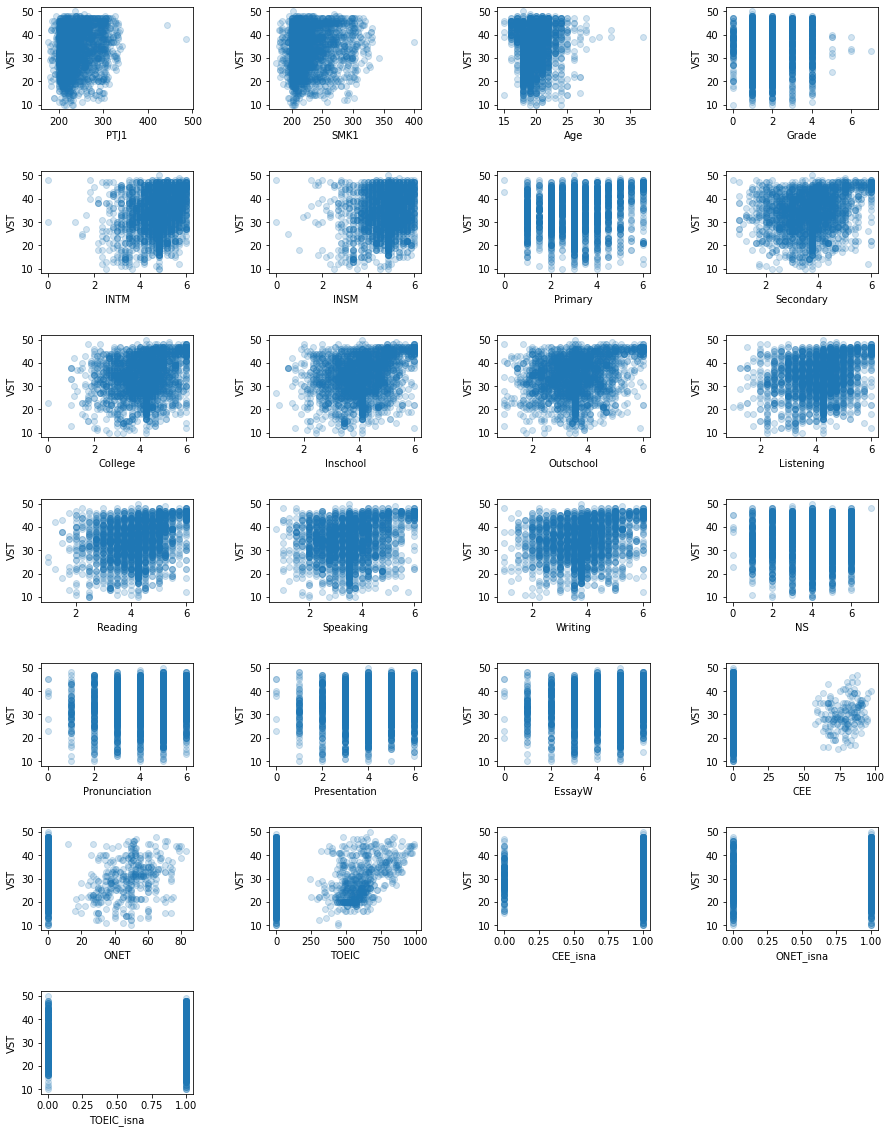

In [27]:
# Quick EDA for feature analysis.
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'VST', data=df, ncol=4, figsize=(15, 20))

In [28]:
ce_hash = ce.HashingEncoder(cols=['Major'])
X = ce_hash.fit_transform(X)

C:\Users\jaeyo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
# Get dummies
X = pd.get_dummies(X, dtype='int64')
X.shape

(2600, 54)

In [30]:
X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,PTJ1,SMK1,Age,Grade,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna,Country_CHN,Country_HKG,Country_IDN,Country_JPN,Country_KOR,Country_PAK,Country_PHL,Country_SIN,Country_THA,Country_TWN,Sex_F,Sex_M,Field_Humanities,Field_Life Sciences,Field_N/A,Field_Sciences & Technology,Field_Social Sciences,CEFR_A2_0,CEFR_B1_1,CEFR_B1_2,CEFR_B2_0
0,0,1,0,0,0,0,0,0,271,219,20,2.0,0.00,0.00,2.0,3.63,4.25,3.89,3.56,4.00,4.50,3.50,3.75,4.0,5.0,5.0,4.0,72.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,0,203,292,21,3.0,4.17,4.33,2.5,4.00,1.86,3.00,2.88,3.00,3.00,2.75,3.33,3.0,3.0,3.0,3.0,77.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,0,1,0,0,0,0,0,0,238,250,20,3.0,5.17,5.17,3.5,4.25,4.25,4.22,4.11,5.00,4.00,3.75,4.25,4.0,5.0,5.0,5.0,79.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,1,0,0,269,230,20,2.0,4.67,5.17,1.0,2.75,4.25,3.44,3.00,3.75,3.75,3.25,3.25,3.0,5.0,5.0,5.0,87.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,1,0,0,225,208,20,2.0,5.17,5.33,2.0,3.63,4.88,4.33,3.67,5.00,5.00,3.25,3.75,3.0,5.0,5.0,5.0,84.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [31]:
# Train Test split. Check their shapes and types
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(1950, 54) (650, 54) (1950,) (650,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [32]:
X_train = X_train.copy()
X_test = X_test.copy()

In [33]:
ptransform = PowerTransformer()

for col in ['PTJ1', 'SMK1']:
    ptransform.fit(X_train[[col]])
    X_train[col] = ptransform.transform(X_train[[col]])
    X_test[col] = ptransform.transform(X_test[[col]])

In [34]:
scaler = MinMaxScaler()

for col in ['CEE', 'ONET', 'TOEIC']:
    scaler.fit(X_train[[col]])
    X_train[col] = scaler.transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

In [35]:
# Random Forest Regressor - initialize
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Parameter grid for gridsearch
params = {
    'n_estimators': [int(n) for n in np.logspace(1,3,5)],
    'max_depth': [None, 10, 20, 30]
}

# 3-fold CV Grid Search, fit, and show top five CV stats.
rf_grid_cv = RandomizedSearchCV(rf, params, cv=3, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'n_estimators': 1000, 'max_depth': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,12.017149,1.335955,2.344715,1.117790,1000,None,"{'n_estimators': 1000, 'max_depth': None}",0.758726,0.794584,0.752845,0.768718,0.018447,1
7,12.380856,0.330102,0.819894,0.639882,1000,10,"{'n_estimators': 1000, 'max_depth': 10}",0.757707,0.793749,0.753935,0.768464,0.017945,2
1,2.507668,0.318436,1.136587,0.639608,316,30,"{'n_estimators': 316, 'max_depth': 30}",0.758165,0.796282,0.750418,0.768289,0.020046,3
5,3.280109,0.184946,0.591782,0.299511,316,20,"{'n_estimators': 316, 'max_depth': 20}",0.758263,0.795726,0.750327,0.768105,0.019798,4
8,3.103839,1.417390,2.513579,0.455401,100,10,"{'n_estimators': 100, 'max_depth': 10}",0.757860,0.795061,0.749158,0.767360,0.019907,5


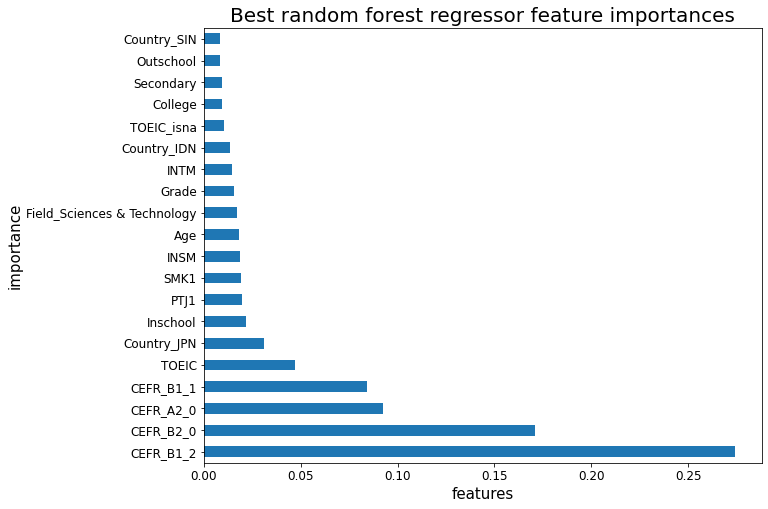

In [36]:
# Manually store best RF estimator as rf_best. Fit to training set.
rf_best = RandomForestRegressor(random_state=42, max_depth=30, n_estimators=1000, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Plot the top 20 feature importances.
plt.subplots(figsize=(10, 8))
imps = rf_best.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:20]
_ = rf_feat_imps.plot(kind='barh', fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances', fontsize=20);
plt.show()

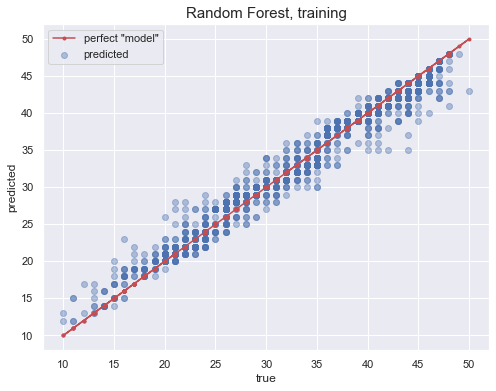

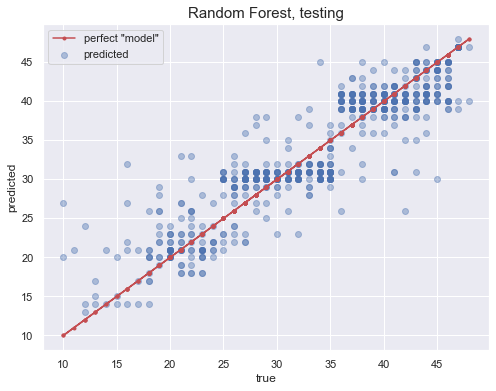

In [37]:
# Predict Training and Test sets with Rf model
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, np.round(y_tr_rf_pred))
pred_plot("Random Forest, testing", y_test, np.round(y_te_rf_pred))

In [38]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.8288964143495001
RMSE:  3.6334819501699873


In [39]:
# XG Boost - initialize.
xg = XGBRegressor(objective='reg:linear', seed=42)
xgb.set_config(verbosity=0)

# Parameter grid for grid searching.
params = {
    'max_depth': range(2, 9),
    'n_estimators': [int(n) for n in np.logspace(start=2, stop=3, num=3)],
    'learning_rate': [n for n in np.logspace(start=-2, stop=0, num=3)]
}

# 3-fold CV Grid search, fit, and print CV stats for top five estimators
xg_grid_cv = RandomizedSearchCV(xg, params, cv=3, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
print(xg_grid_cv.best_params_)
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,6.623056,0.299518,0.006988,0.001405,1000,6,0.01,"{'n_estimators': 1000, 'max_depth': 6, 'learni...",0.748645,0.759232,0.745414,0.751097,0.005902,1
9,0.668992,0.028858,0.004989,0.000012,100,5,0.1,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",0.746947,0.759405,0.746106,0.750819,0.006081,2
3,0.986810,0.043263,0.006676,0.000939,100,6,0.1,"{'n_estimators': 100, 'max_depth': 6, 'learnin...",0.743192,0.757320,0.739846,0.746786,0.007573,3
1,5.190275,0.152757,0.006824,0.000238,316,8,0.01,"{'n_estimators': 316, 'max_depth': 8, 'learnin...",0.725768,0.712645,0.664000,0.700804,0.026570,4
2,0.767425,0.311611,0.004987,0.000815,100,2,1.0,"{'n_estimators': 100, 'max_depth': 2, 'learnin...",0.690176,0.706382,0.671481,0.689346,0.014261,5


In [40]:
# Parameter grid for grid searching.
params = {
    'max_depth': range(3, 7),
    'n_estimators': [int(n) for n in np.logspace(start=2, stop=3, num=3)],
    'learning_rate': [0.01, 0.1]
}

# 3-fold CV Grid search, fit, and print CV stats for top five estimators
xg_grid_cv = GridSearchCV(xg, params, cv=3, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
print(xg_grid_cv.best_params_)
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:3]

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,0.711314,0.027080,0.006317,0.000470,0.1,4,100,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.747517,0.772543,0.748266,0.756109,0.011625,1
5,5.363531,0.123918,0.006981,0.000815,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.746466,0.769443,0.749195,0.755035,0.010249,2
12,0.572682,0.032769,0.006316,0.000470,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.744214,0.767370,0.748938,0.753507,0.009990,3


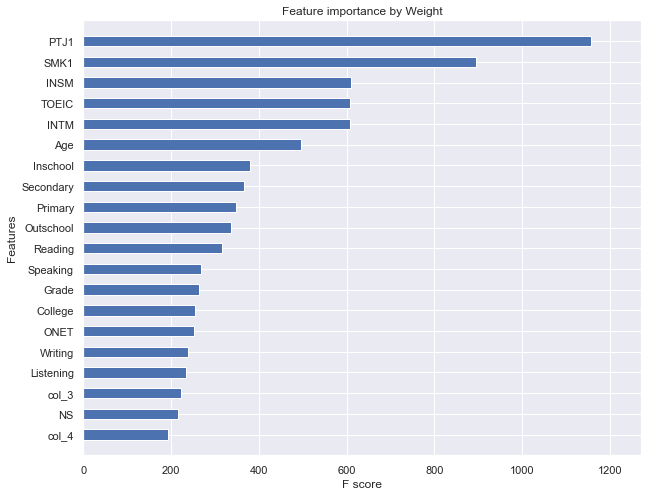

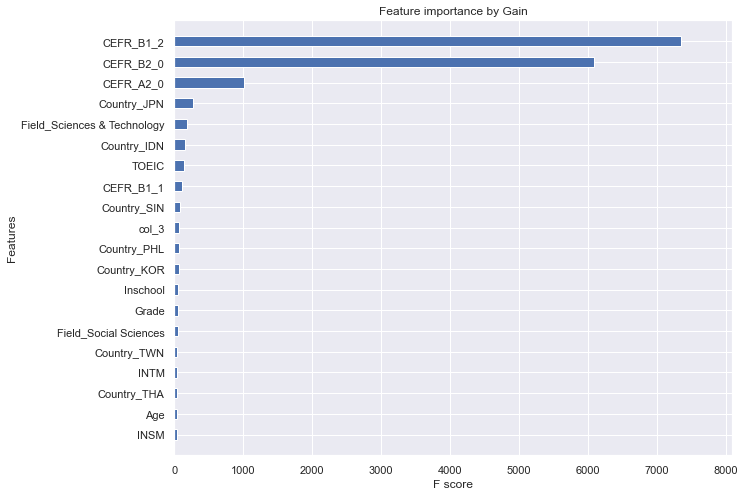

In [44]:
# Manually store best XG Boost model as xg_best. Fit to training set.
xg_best = XGBRegressor(objective='reg:linear', learning_rate=0.031623, max_depth=6, n_estimators=316, seed=42)
xg_best.fit(X_train, y_train)

# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

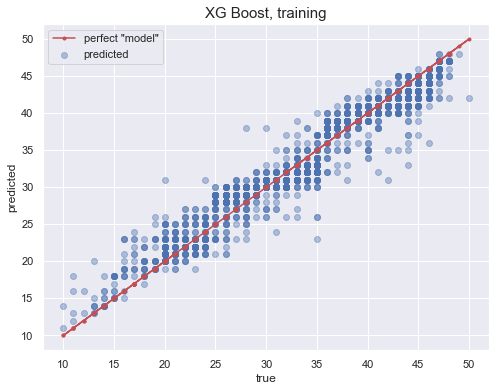

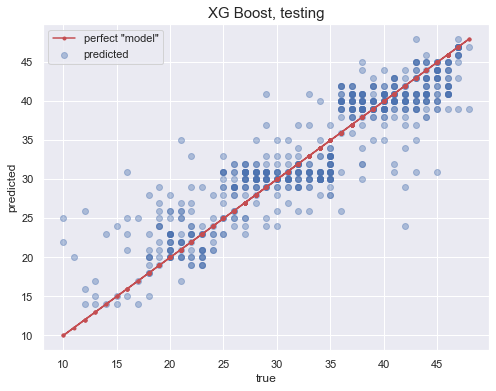

In [45]:
# Predict on Training and Test sets using XG Boost model
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, np.round(y_tr_xg_pred))
pred_plot("XG Boost, testing", y_test, np.round(y_te_xg_pred))

In [46]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.8216864485660202
RMSE:  3.709245911654592


In [47]:
# Initialize pipeline for optional StandardScaler followed by Lasso regression
scaler = StandardScaler()
lasso = Lasso(random_state=42)
pipe = make_pipeline(scaler, lasso)

# Parameter grid for pipeline - scaler is optional.
params = {
    'standardscaler': [StandardScaler(), None],
    'lasso__alpha': [n for n in np.logspace(-6,0,13)],
    'lasso__max_iter': [1000, 3000, 10000]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(pipe, params, cv=3, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'lasso__alpha': 0.00031622776601683794, 'lasso__max_iter': 10000, 'standardscaler': None}


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15494.58246394097, tolerance: 14.61748517948718
  model = cd_fast.enet_coordinate_descent(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_lasso__max_iter,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
35,1.776676,0.047218,0.006051,0.000815,0.000316,10000,None,"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.687745,0.717036,0.714934,0.706571,0.013340,1
34,1.554144,0.065945,0.007001,0.000800,0.000316,10000,StandardScaler(),"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.687685,0.716939,0.715067,0.706563,0.013371,2
29,1.906227,0.073004,0.018378,0.009812,0.0001,10000,None,"{'lasso__alpha': 0.0001, 'lasso__max_iter': 10...",0.687633,0.716757,0.715278,0.706556,0.013394,3
28,1.706272,0.094260,0.008678,0.003086,0.0001,10000,StandardScaler(),"{'lasso__alpha': 0.0001, 'lasso__max_iter': 10...",0.687608,0.716723,0.715325,0.706552,0.013407,4
23,1.715042,0.099515,0.007149,0.002086,0.000032,10000,None,"{'lasso__alpha': 3.1622776601683795e-05, 'lass...",0.687573,0.716657,0.715195,0.706475,0.013379,5


In [48]:
# Set lasso_best to alpha=0.000316, max_iter=10000. Fit to training set.
lasso_best = Lasso(alpha=0.00031623, max_iter=10000, random_state=42)
lasso_best.fit(X_train, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15494.558623868379, tolerance: 14.61748517948718
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.00031623, max_iter=10000, random_state=42)

In [49]:
# For plotting purposes - keep only the coefficients of absolute value > 0.2 to keep the plot visually comprehensible
lasso_coefs = pd.DataFrame(lasso_best.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs = lasso_coefs[abs(lasso_coefs.coef) > 0.2]

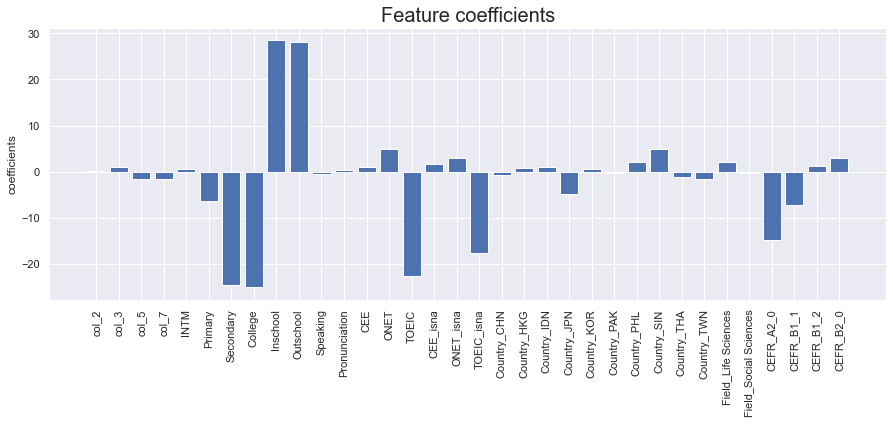

In [50]:
# Plot feature coefficients of Lasso regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs.index, lasso_coefs.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

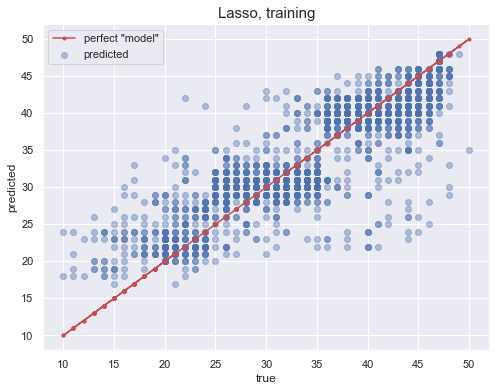

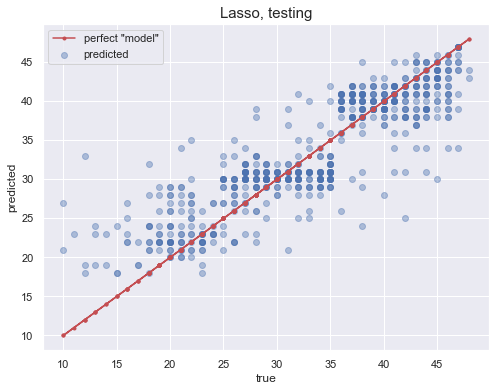

In [51]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = lasso_best.predict(X_train)
y_te_lasso_pred = lasso_best.predict(X_test)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, np.round(y_tr_lasso_pred))
pred_plot("Lasso, testing", y_test, np.round(y_te_lasso_pred))

In [52]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.7682351313348657
RMSE:  4.228801058503084


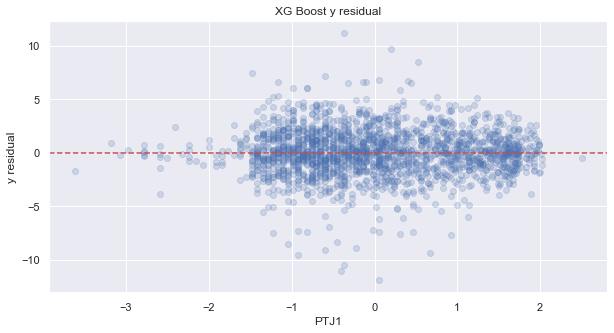

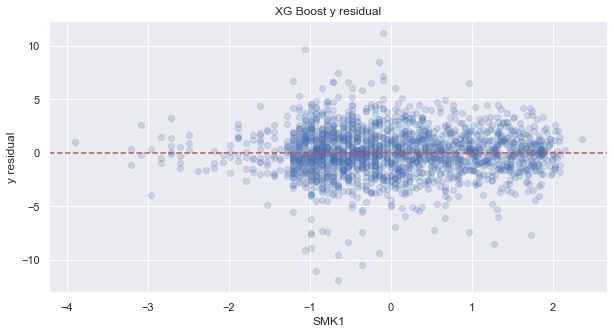

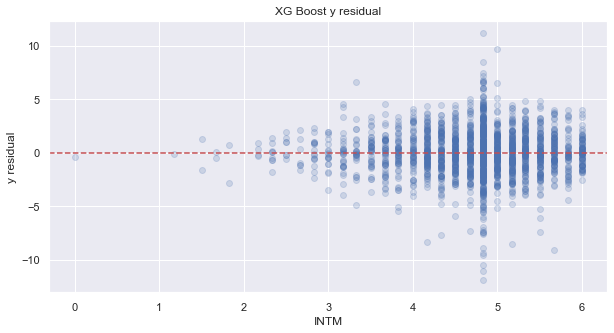

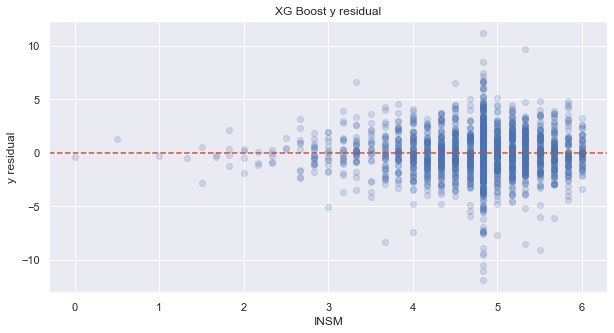

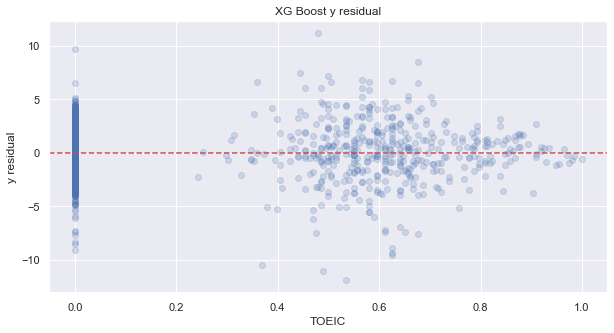

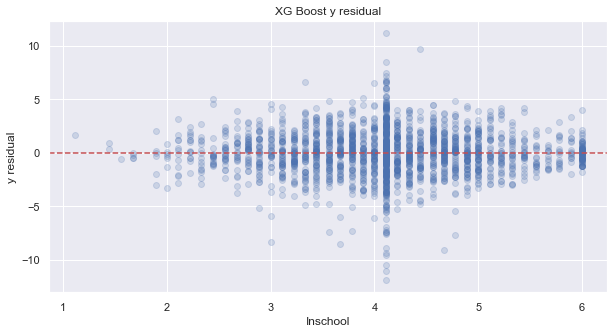

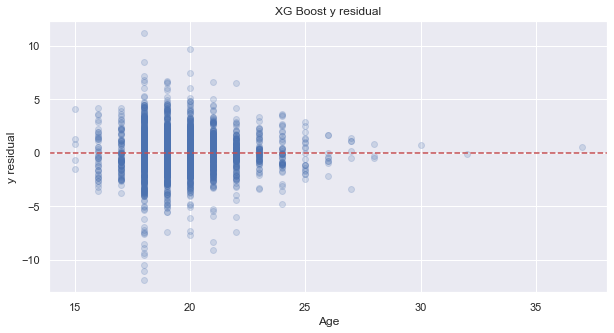

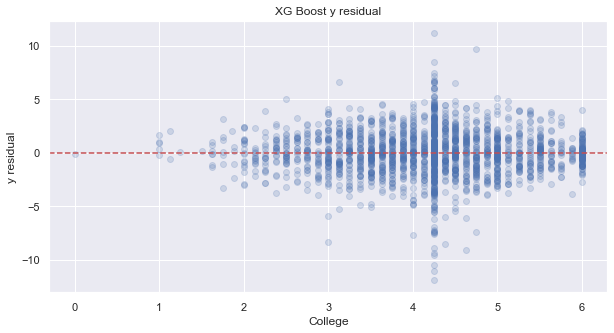

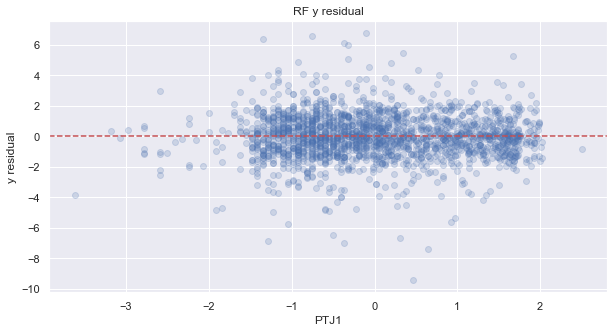

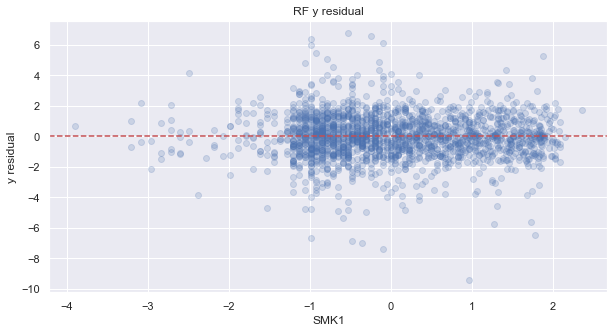

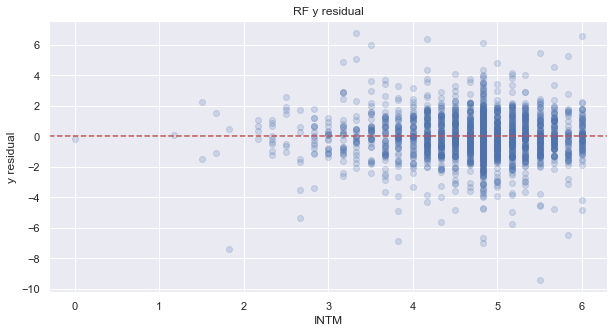

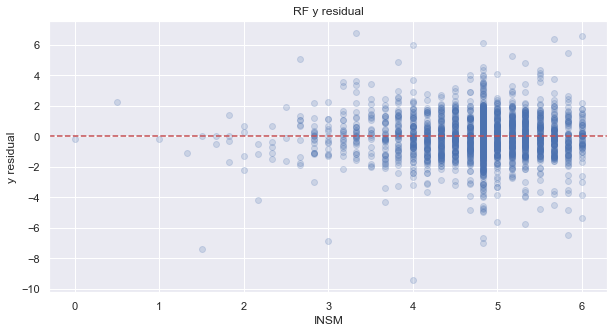

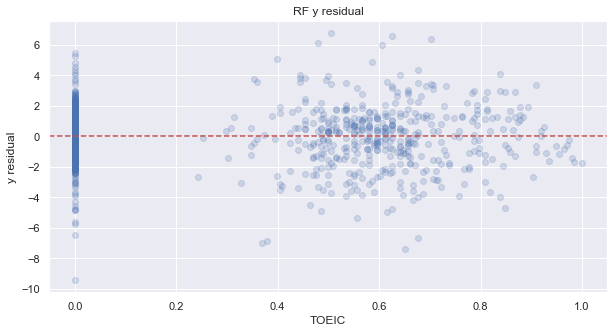

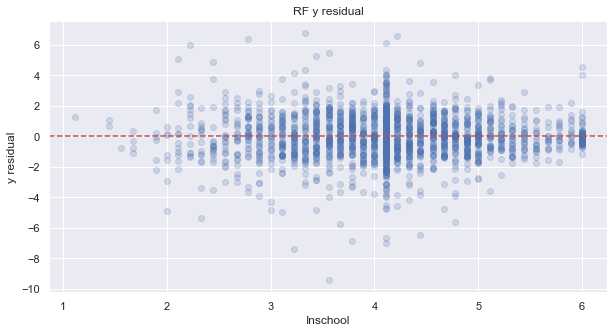

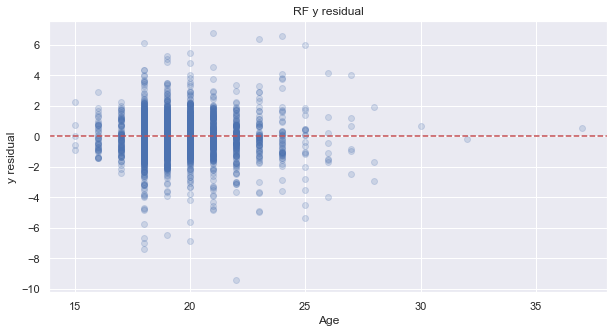

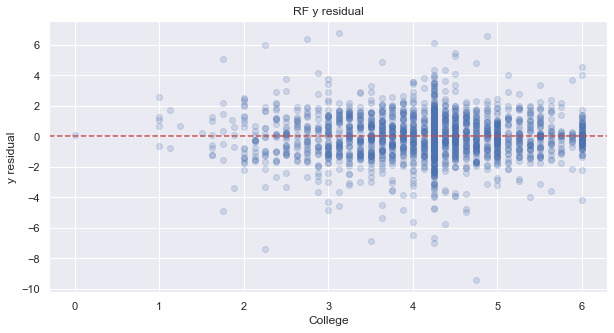

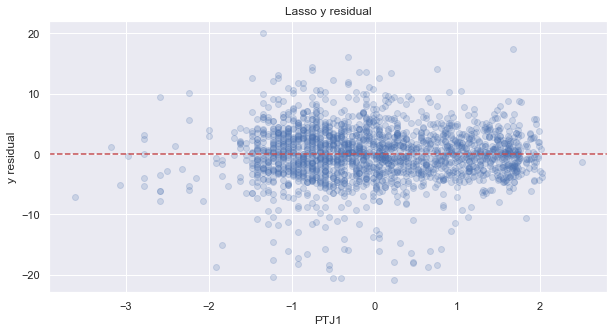

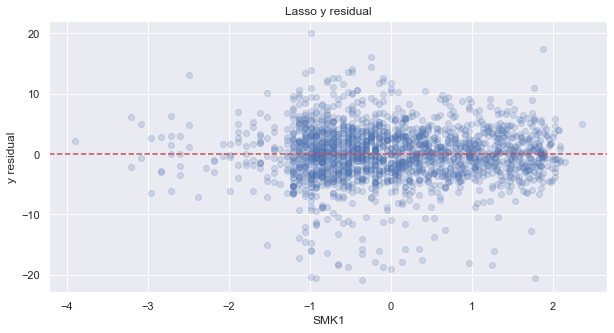

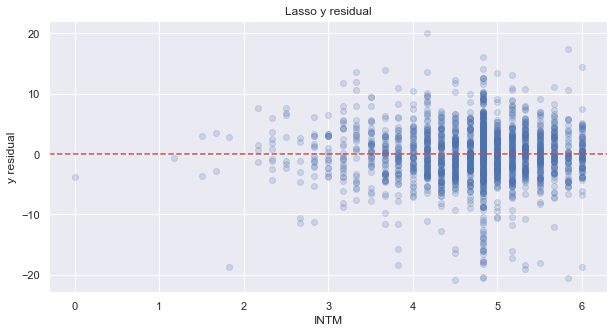

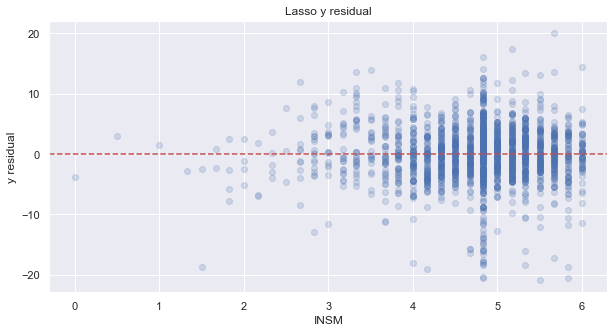

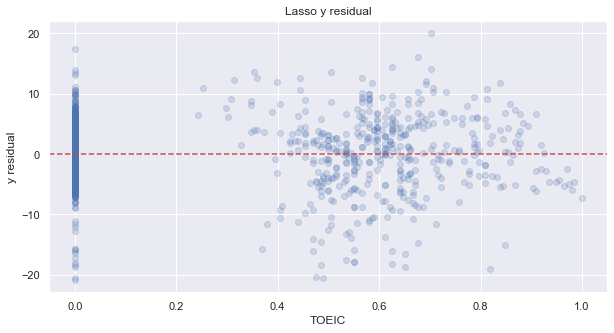

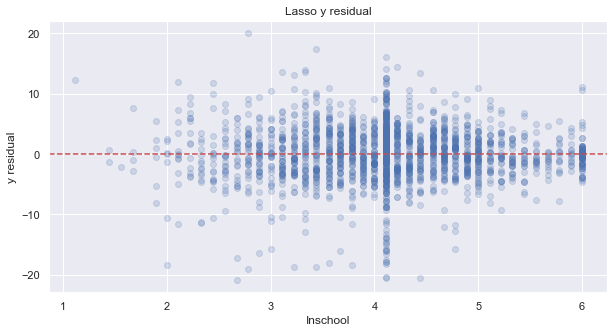

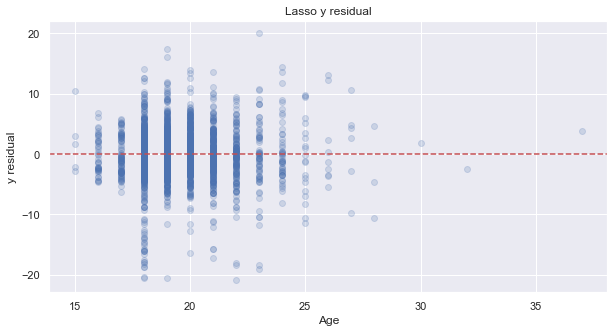

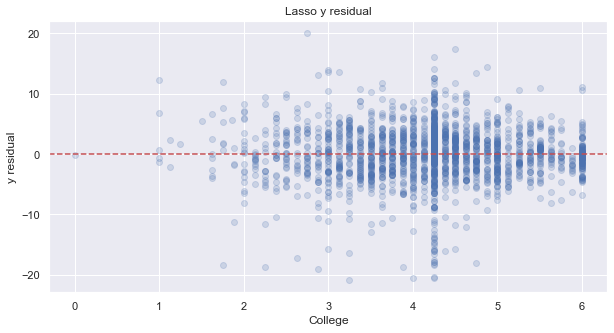

In [53]:
# Highest weight continuous columns for XG Boost
cols = ['PTJ1', 'SMK1', 'INTM', 'INSM', 'TOEIC', 'Inschool', 'Age', 'College']

# XG Boost Training prediction residuals
y_tr_xg_res = y_tr_xg_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_xg_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('XG Boost y residual')
    plt.show()
    
# RF Training prediction residuals
y_tr_rf_res = y_tr_rf_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_rf_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('RF y residual')
    plt.show()
    
# Lasso Training prediction residuals
y_tr_lasso_res = y_tr_lasso_pred - y_train

for c in cols:
    fig = plt.figure(figsize=(10,5))
    _ = plt.scatter(X_train[c], y_tr_lasso_res, alpha=0.2)
    _ = plt.axhline(0, c='r', linestyle='--')
    _ = plt.xlabel(c)
    _ = plt.ylabel('y residual')
    _ = plt.title('Lasso y residual')
    plt.show()